# Dataloop Dataloader  
A dl.Dataset image and annotation generator for training and for items visualization  
  
We can visualize the data with augmentation for debug and exploration.  
After that, we will use the Data Generator as an input to the training functions  


In [1]:
from dtlpy.utilities import DatasetGenerator
import dtlpy as dl
dataset = dl.datasets.get(dataset_id='611b86e647fe2f865323007a')
dataloader = DatasetGenerator(data_path='train',
                              dataset_entity=dataset,
                              annotation_type=dl.AnnotationType.BOX)


[2022-02-27 17:53:22][WAR][dtlpy:v1.52.0][repositories.recipes:147] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list
[2022-02-27 17:53:23][WAR][dtlpy:v1.52.0][repositories.ontologies:216] Deprecation Warning - return type will be pageEntity from version 1.46.0 not a list
Loading Data Generator: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1886.80it/s]


## Object Detection Examples  
We can visualize a random item from the dataset:  


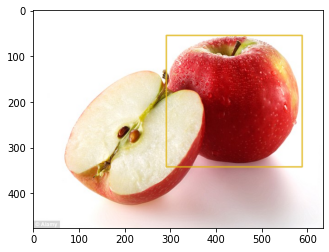

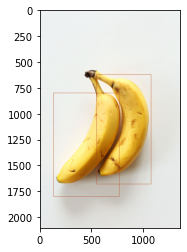

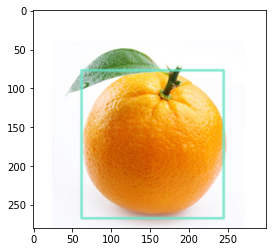

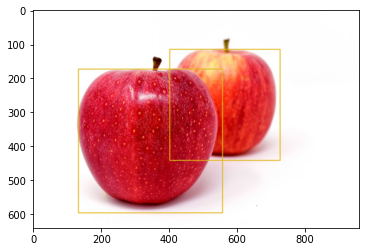

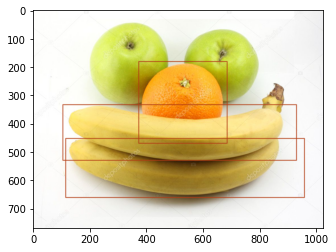

In [3]:
for i in range(5):
    dataloader.visualize()


Or get the same item using it's index:  


In [0]:
for i in range(5):
    dataloader.visualize(10)


Adding augmentations using imgaug repository:  


In [0]:
from imgaug import augmenters as iaa
import numpy as np
augmentation = iaa.Sequential([
    iaa.Resize({"height": 256, "width": 256}),
    # iaa.Superpixels(p_replace=(0, 0.5), n_segments=(10, 50)),
    iaa.flip.Fliplr(p=0.5),
    iaa.flip.Flipud(p=0.5),
    iaa.GaussianBlur(sigma=(0.0, 0.8)),
])
tfs = [
    augmentation,
    np.copy,
    # transforms.ToTensor()
]
dataloader = DatasetGenerator(data_path='train',
                              dataset_entity=dataset,
                              annotation_type=dl.AnnotationType.BOX,
                              transforms=tfs)
dataloader.visualize()
dataloader.visualize(10)


All of the Data Generator options (from the function docstring):  
  
:param dataset_entity: dl.Dataset entity  
:param annotation_type: dl.AnnotationType - type of annotation to load from the annotated dataset  
:param filters: dl.Filters - filtering entity to filter the dataset items  
:param data_path: Path to Dataloop annotations (root to "item" and "json").  
:param overwrite:  
:param label_to_id_map: dict - {label_string: id} dictionary  
:param transforms: Optional transform to be applied on a sample. list or torchvision.Transform  
:param num_workers:  
:param shuffle: Whether to shuffle the data (default: True) If set to False, sorts the data in alphanumeric order.  
:param seed: Optional random seed for shuffling and transformations.  
:param to_categorical: convert label id to categorical format  
:param class_balancing: if True - performing random over-sample with class ids as the target to balance training data  
:param return_originals: bool - If True, return ALSO images and annotations before transformations (for debug)  
:param ignore_empty: bool - If True, generator will NOT collect items without annotations  
  
  
The output of a single element is a dictionary holding all the relevant informtaion.  
the keys for the DataGen above are: ['image_filepath', 'item_id', 'box', 'class', 'labels', 'annotation_filepath', 'image', 'annotations', 'orig_image', 'orig_annotations']  


In [0]:
print(list(dataloader[0].keys()))


We'll add the flag to return the origin items to understand better how the augmentations look like.  
Let's set the flag and we can plot:  


In [0]:
import matplotlib.pyplot as plt
dataloader = DatasetGenerator(data_path='train',
                              dataset_entity=dataset,
                              annotation_type=dl.AnnotationType.BOX,
                              return_originals=True,
                              shuffle=False,
                              transforms=tfs)
fig, ax = plt.subplots(2, 2)
for i in range(2):
    item_element = dataloader[np.random.randint(len(dataloader))]
    ax[i, 0].imshow(item_element['image'])
    ax[i, 0].set_title('After Augmentations')
    ax[i, 1].imshow(item_element['orig_image'])
    ax[i, 1].set_title('Before Augmentations')


## Segmentation Examples  
First we'll load a semantic dataset and view some images and the output structure  
  


In [0]:
dataset = dl.datasets.get(dataset_id='6197985a104eb81cb728e4ac')
dataloader = DatasetGenerator(data_path='semantic',
                              dataset_entity=dataset,
                              transforms=tfs,
                              return_originals=True,
                              annotation_type=dl.AnnotationType.SEGMENTATION)
for i in range(5):
    dataloader.visualize()


Visualize original vs augmented image and annotations mask:  


In [0]:
fig, ax = plt.subplots(2, 4)
for i in range(2):
    item_element = dataloader[np.random.randint(len(dataloader))]
    ax[i, 0].imshow(item_element['orig_image'])
    ax[i, 0].set_title('Original Image')
    ax[i, 1].imshow(item_element['orig_annotations'])
    ax[i, 1].set_title('Original Annotations')
    ax[i, 2].imshow(item_element['image'])
    ax[i, 2].set_title('Augmented Image')
    ax[i, 3].imshow(item_element['annotations'])
    ax[i, 3].set_title('Augmented Annotations')


Converting to 3d one-hot to visualize the binary mask per label. We will plot only 8 label (there might be more on the item):  


In [0]:
item_element = dataloader[np.random.randint(len(dataloader))]
annotations = item_element['annotations']
unique_labels = np.unique(annotations)
one_hot_annotations = np.arange(len(dataloader.id_to_label_map)) == annotations[..., None]
print('unique label indices in the item: {}'.format(unique_labels))
print('unique labels in the item: {}'.format([dataloader.id_to_label_map[i] for i in unique_labels]))
plt.figure()
plt.imshow(item_element['image'])
fig = plt.figure()
for i_label_ind, label_ind in enumerate(unique_labels[:8]):
    ax = fig.add_subplot(2, 4, i_label_ind + 1)
    ax.imshow(one_hot_annotations[:, :, label_ind])
    ax.set_title(dataloader.id_to_label_map[label_ind])
